# Forecast Phase 1

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from minisom import MiniSom
from collections import Counter
from sklearn.metrics import silhouette_score

from data_prep import data_prep
import get_model
import utils

seed = 42
np.random.seed(seed)

## Prep Data

In [2]:
# Read datasets
df_bio = pd.read_csv('dataset\Biomass_History.csv')
df_dist = pd.read_csv('dataset\Distance_Matrix.csv')
submission = pd.read_csv('dataset\sample_submission.csv')
df_ext = pd.read_excel('dataset\External_Data.xlsx')
df_real = pd.read_csv('dataset\Biomass_Private.csv')

data_loader = data_prep()
data_loader.create_images(width=80, height=64)
selected_pix = data_loader.selected_pix
images = data_loader.get_images()

In [3]:
# Expand dfbio dataset
df_bio_long = pd.melt(df_bio, id_vars=['Index','Latitude','Longitude'], var_name='Year', value_name='Bio')
df_bio_long['Year'] = df_bio_long['Year'].astype(int)
df_bio_long['Bio'] = df_bio_long['Bio'].astype(float)

years = [str(year) for year in range(2010,2017+1)]
df_bio['mean_bio'] = df_bio.apply(lambda x: np.mean(x[years]),axis=1)

In [4]:
# Aggregate external dataset
df_ext_annual = df_ext.groupby('Year').agg({
    "Avg_Temp" : "mean",
    "Min_Temp" : "min",
    "Max_Temp" : "max",
    "Rainfall" : "sum",
    "Rain_Days" : "sum",
    "Cloud" : "mean",
    "Humidity" : "mean",
    "Sun_Hours" : "sum",
    "Sun_Days" : "sum",
    "UV_Index" : "mean",
    "Pressure": "mean",
    "Avg_Gust": "mean",
    "Max_Wind": "max",
    "Avg_Wind": "mean",
}).reset_index()

In [5]:
df_train = df_bio_long.copy()
df_2018 = df_bio_long.loc[df_bio_long['Year'] == 2010].drop(columns=['Bio'])
df_2018['Year'] = 2018
df_2019 = df_bio_long.loc[df_bio_long['Year'] == 2010].drop(columns=['Bio'])
df_2019['Year'] = 2019

In [6]:
class SOMClassifier:
    def __init__(self, som_x=5, som_y=5, learning_rate=0.05):
        self.som_x = som_x
        self.som_y = som_y
        self.learning_rate = learning_rate

    def train(self, dfts_norm):
        series_data = dfts_norm.drop(columns=['Index']).values

        self.som = MiniSom(self.som_x, self.som_y, input_len=series_data.shape[1], learning_rate=self.learning_rate, random_seed=42)
        self.som.random_weights_init(series_data)

        num_epochs = 50000
        self.som.train_random(series_data, num_epochs)

        self.winners = self.som.win_map(series_data)

        cluster_indices = list(self.winners.keys())
        self.winners_indexed = {f"Cluster {i+1}": self.winners[cluster_indices[i]] for i in range(len(cluster_indices))}

        self.list_of_series = np.array([series for series_list in self.winners_indexed.values() for series in series_list])

        self.cluster_labels = []
        for cluster, series_list in self.winners_indexed.items():
            self.cluster_labels.extend([cluster] * len(series_list))

        self.cluster_labels = np.array(self.cluster_labels)

    def get_silhouette_score(self):
        silhouette_avg = silhouette_score(self.list_of_series, self.cluster_labels)
        return silhouette_avg
    
    def plot_cluster(self):
        fig, axs = plt.subplots(self.som_x,self.som_y,figsize=(min(self.som_x,self.som_y)*5,max(self.som_x,self.som_y)*5))
        for x in range(self.som_x):
            for y in range(self.som_y):
                cluster = (x,y)
                if cluster in self.winners.keys():
                    for series in self.winners[cluster]:
                        axs[cluster].plot(series,c="gray",alpha=0.5) 
                    axs[cluster].plot(dtw_barycenter_averaging(np.vstack(self.winners[cluster])),c="red")
                cluster_number = x*self.som_y+y+1
                axs[cluster].set_title(f"Cluster {cluster_number}")
            
        plt.tight_layout()
        plt.show()

    def get_df_label(self):
        columns = ['2010','2011','2012','2013','2014','2015','2016','2017','Label']
        dflabel = pd.DataFrame(columns=columns)

        rows = []
        for cluster, series_list in self.winners_indexed.items():
            for series in series_list:
                new_row = {'2010': series[0], '2011': series[1], '2012': series[2],
                        '2013': series[3], '2014': series[4], '2015': series[5],
                        '2016': series[6], '2017': series[7], 'Label': cluster}
                rows.append(new_row)

        dflabel = pd.concat([dflabel, pd.DataFrame(rows)], ignore_index=True)
        dflabel = df_ts_norm.merge(dflabel, on=list(year_cols), how='left').drop(columns=list(year_cols))
        return dflabel
    
    def plot_distribution(self):
        df = self.get_df_label()
        df['Label'].value_counts().plot(kind='bar', figsize=(15,4), title='Distribution')
    
    

In [7]:
# Create dataframe for timeseries clustering
df_ts = df_bio.drop(columns=['Latitude','Longitude','mean_bio'])
year_cols = df_ts.columns[1:]

# Create a normalized dataframe and expand
df_ts_norm = df_ts.copy()
df_ts_norm[year_cols] = df_ts_norm.apply(lambda row: (row[year_cols] - row[year_cols].min())/row[year_cols].max(), axis=1)
df_ts_long = pd.melt(df_ts_norm, id_vars=['Index'], var_name='Year', value_name='Bio')

som_x = 3
som_y = 3
som_classifier = SOMClassifier(som_x=som_x, som_y=som_y)

som_classifier.train(df_ts_norm)

som_silhouette_score = som_classifier.get_silhouette_score()
print(f'Silhouette Score: {som_silhouette_score}')

dfmean = df_bio_long.groupby(['Index','Latitude','Longitude'])['Bio'].mean().reset_index()
dflabel = som_classifier.get_df_label()

Silhouette Score: 0.20505389281858416


## Feature Engineering Functions

In [8]:
def add_temporal(dftrain, df2018, df2019, past_count):
    for i in range(1,past_count+1):
        df_lag=df_bio_long.copy()[['Index','Year','Bio']]
        df_lag['Year'] = df_lag['Year']+i
        dftrain = dftrain.merge(df_lag, on=['Index', 'Year'], how='left',suffixes=('',f'_plus{i}'))
        df2018 = df2018.merge(df_lag, on=['Index', 'Year'], how='left',suffixes=('',f'_plus{i}'))
        df2019 = df2019.merge(df_lag, on=['Index', 'Year'], how='left',suffixes=('',f'_plus{i}'))
    
    df2018.rename(columns={'Bio': 'Bio_plus1'}, inplace=True)
    df2019.rename(columns={'Bio': 'Bio_plus1'}, inplace=True)
    return dftrain,df2018,df2019

def add_spatial(df_train, df_2018, df_2019, n_closest):
    dftrain, df2018, df2019 = df_train.copy(), df_2018.copy(), df_2019.copy()
    df_closest = pd.DataFrame(df_bio['Index'])
    df_closest['closest'] = df_bio['Index'].apply(lambda x: df_dist[str(x)].nsmallest(n_closest).index.tolist())

    for i in range(n_closest):
        dftrain['closest_'+str(i)] = dftrain.apply(lambda x:
                                                        np.nan if str(int(x['Year'])-1) not in years else
                                                        df_bio.loc[df_closest.loc[int(x['Index'])]['closest'][i],str(int(x['Year'])-1)],
                                                        axis=1)
        
        df2018['closest_'+str(i)] = df2018.apply(lambda x:
                                                        np.nan if str(int(x['Year'])-1) not in years else
                                                        df_bio.loc[df_closest.loc[int(x['Index'])]['closest'][i],str(int(x['Year'])-1)],
                                                        axis=1)
        
        df2019['closest_'+str(i)] = df2019.apply(lambda x:
                                                        np.nan if str(int(x['Year'])-1) not in years else
                                                        df_bio.loc[df_closest.loc[int(x['Index'])]['closest'][i],str(int(x['Year'])-1)],
                                                        axis=1)
    
    return dftrain, df2018, df2019

def add_label(dftrain, df2018, df2019, df_label, OHE=False): 
    dftrain = pd.merge(dftrain, df_label)
    df2018 = pd.merge(df2018, df_label)
    df2019 = pd.merge(df2019, df_label)
    if OHE :
        return pd.get_dummies(dftrain, columns=['Label']),pd.get_dummies(df2018, columns=['Label']),pd.get_dummies(df2019, columns=['Label'])
    else :
        return dftrain, df2018, df2019

def add_ext(dftrain, df2018, df2019, df_ext):
    return pd.merge(dftrain, df_ext, on='Year', how='left'),pd.merge(df2018, df_ext, on='Year', how='left'),pd.merge(df2019, df_ext, on='Year', how='left')

In [9]:
df_train_regres, df_2018_regres, df_2019_regres = add_ext(df_train, df_2018, df_2019, df_ext_annual)

df_st_train_whole, df_st_2018_whole, df_st_2019_whole = add_spatial(df_train, df_2018, df_2019, 5)
df_st_train_whole, df_st_2018_whole, df_st_2019_whole = add_temporal(df_st_train_whole, df_st_2018_whole, df_st_2019_whole, 3)
df_stc_train_whole, df_stc_2018_whole, df_stc_2019_whole = add_label(df_st_train_whole, df_st_2018_whole, df_st_2019_whole, dflabel, OHE=True)
df_ste_train_whole, df_ste_2018_whole, df_ste_2019_whole = add_ext(df_st_train_whole, df_st_2018_whole, df_st_2019_whole, df_ext_annual)
df_stce_train_whole, df_stce_2018_whole, df_stce_2019_whole = add_ext(df_stc_train_whole, df_stc_2018_whole, df_stc_2019_whole, df_ext_annual)

## Predictive Models

In [10]:
# Import machine learning frameworks
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf

### Classical ML

In [ ]:
def create_pipeline(model, scaler):
    pipeline = Pipeline([
        ('scaler', scaler),  # Standardize the features
        ('model', model)  # Your chosen model
    ])
    return pipeline

def lr_schedule(epoch):
    if epoch < 100:
        return 0.001
    elif epoch < 200:
        return 0.0005
    elif epoch < 300:
        return 0.0001
    elif epoch < 400:
        return 0.00005
    else :
        return 0.00001

def eval_whole(model, splits, dftrain):
    train_err = []
    valid_err = []

    X = dftrain.copy().drop(columns=['Index','closest_0'])
    y = X.pop('Bio')

    tscv = TimeSeriesSplit(n_splits=splits, test_size=2418)

    for train_index, valid_index in tscv.split(X):
        valid_year = X.iloc[valid_index]['Year'].unique()[0]
        # print(f"Testing on year : {valid_year}")

        x_train, y_train = X.iloc[train_index], y.iloc[train_index]
        x_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]

        pipeline = create_pipeline(model, MinMaxScaler())

        pipeline.fit(x_train, y_train)

        train_pred = pipeline.predict(x_train)
        valid_pred = pipeline.predict(x_valid)

        train_score = mean_absolute_error(y_train, train_pred)
        valid_score = mean_absolute_error(y_valid, valid_pred)

        train_err.append(train_score)
        valid_err.append(valid_score)

    print(f'Mean Train Score : {np.mean(train_err):.5f}, Mean Valid Score : {np.mean(valid_err):.5f}')

    return train_err, valid_err, pipeline

def eval_linear(model, dftrain):
    mae_list = []
    for i in dftrain['Index'].unique():
        X = dftrain[dftrain['Index']==i].copy().drop(['Index','Latitude','Longitude'],axis=1)
        y = X.pop('Bio')

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
        pipeline = create_pipeline(model, MinMaxScaler())
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mae_list.append(mae)

    print(f"Mean Absolute Error (MAE): {np.mean(mae_list)}")
    return mae_list
    
def eval_nn(model, dftrain):
    X = dftrain.copy().drop(['Index','closest_0','Latitude', 'Longitude'],axis=1)
    X_train = X[X['Year']<2017]
    y_train = X_train.pop('Bio')
    X_test = X[X['Year']==2017]
    y_test = X_test.pop('Bio')
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = X_train_scaled[:,1:]
    X_test_scaled = X_test_scaled[:,1:]

    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=150, verbose=1, restore_best_weights=True)
    
    _ = model.fit(X_train_scaled, y_train, epochs=250, batch_size=512, validation_data=(X_test_scaled, y_test))

    loss = model.evaluate(X_test_scaled, y_test)
    print(f'Mean Absolute Error: {loss:.4f}')

    return loss,_

In [13]:
error_dict = {}

In [ ]:
df_st_train_whole.dropna(inplace=True)
df_stc_train_whole.dropna(inplace=True)
df_ste_train_whole.dropna(inplace=True)
df_stce_train_whole.dropna(inplace=True)

datasets = {
    # 'ST' : df_st_train_whole,
    # 'STC' : df_stc_train_whole,
    # 'STE' : df_ste_train_whole,
    'STCE' : df_stce_train_whole
}

models = {
    'RF' : RandomForestRegressor(random_state=seed, verbose=0),
    'LGBM' : LGBMRegressor(random_state=seed, verbosity=-1)
}

models_linear = {
    # 'LinReg' : LinearRegression(),
    # 'Ridge' : Ridge(random_state=seed),
    'Enet' : ElasticNet(random_state=seed)
}

In [ ]:
for model in models.keys():
    for data in datasets.keys():
        print(f'Model {model}, Data {data}')
        t_err, v_err, train_model = eval_whole(models[model], 4, datasets[data])
        error_dict[model+'_'+data] = np.mean(v_err)

In [ ]:
for model in models_linear.keys() :
    print(f'Model {model}')
    err = eval_linear(models_linear[model], df_train_regres)
    error_dict[model] = np.mean(err)

In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(48, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)  
        ])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mean_absolute_error')

loss, history = eval_nn(model, df_st_train_whole)

In [ ]:
error_dict['ANN'] = loss

# Access the training and validation loss from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs for x-axis
epochs = range(1, len(train_loss) + 1)
offset = 10

# Plotting
plt.plot(epochs[offset:], train_loss[offset:], 'b', label='Training loss')
plt.plot(epochs[offset:], val_loss[offset:], 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show plot
plt.show()

In [11]:
image_data = data_loader.dfbio

In [14]:
unet = get_model.Unet(image_data, images)

_, _, X_val_unet, y_val_unet = unet.prepare_data(fit=False)
model_unet = unet.get_model()
model_unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mae')

model_unet.load_weights('saved_models\\Unet_250_29.472_val.h5')

error_dict['Unet'] = model_unet.evaluate(X_val_unet, y_val_unet)

1/1 [==============================] - 0s 291ms/step - loss: 29.4792


In [15]:
lstm_3 = get_model.LSTM_3(image_data)

_, _, X_val_lstm, y_val_lstm = lstm_3.prepare_data(fit=False)
model_lstm = lstm_3.get_model()
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae')

model_lstm.load_weights('saved_models\\LSTM_3_300_35.187_val.h5')

error_dict['LSTM'] = model_lstm.evaluate(X_val_lstm, y_val_lstm)

1/1 [==============================] - 0s 417ms/step - loss: 35.0586


In [ ]:
clstm_3 = get_model.ConvLSTM_3(image_data, images)

_, _, X_val_clstm, y_val_clstm = clstm_3.prepare_data(fit=False)
model_clstm = clstm_3.get_model()
model_clstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mae')

model_clstm.load_weights('saved_models\\ConvLSTM_M_300_27.30_val.h5')

error_dict['ConvLSTM'] = model_clstm.evaluate(X_val_clstm, y_val_clstm)

In [ ]:
X_val_clstm.shape, y_val_clstm.shape

In [ ]:
sorted_error_dict = dict(sorted(error_dict.items(), key=lambda item: item[1], reverse=True))

sns.barplot(x=list(sorted_error_dict.keys()), y=list(sorted_error_dict.values()), palette='deep')

plt.title('Model Comparison')
plt.ylabel('MAE')

plt.xticks(rotation=45)
plt.show()

In [ ]:
def pred_linear(df_train, df_2018, df_2019, model):
    pred_dict = {'2018': [], '2019': []}  # Initialize a dictionary to store predictions

    # Loop through unique 'Index' values in df_train
    for i in df_train['Index'].unique():
        # Extract features and target for training
        X = df_train[df_train['Index'] == i].drop(['Index','Latitude','Longitude'],axis=1)
        y = X.pop('Bio')

        # Extract features for testing in 2018 and 2019
        X_2018 = df_2018[df_2018['Index'] == i].drop(['Index','Latitude','Longitude'],axis=1)
        X_2019 = df_2019[df_2019['Index'] == i].drop(['Index','Latitude','Longitude'],axis=1)

        # Create and fit the pipeline
        pipeline = create_pipeline(model, MinMaxScaler())
        _ = pipeline.fit(X, y)

        # Make predictions for 2018 and 2019
        pred_2018 = pipeline.predict(X_2018)
        pred_2019 = pipeline.predict(X_2019)

        # Append predictions to the dictionary
        pred_dict['2018'].append(int(pred_2018))
        pred_dict['2019'].append(int(pred_2019))

    return pred_dict

In [ ]:
model = ElasticNet()
predictions = pred_linear(df_train_regres, df_2018_regres, df_2019_regres, model)

1/1 [==============================] - 0s 32ms/step


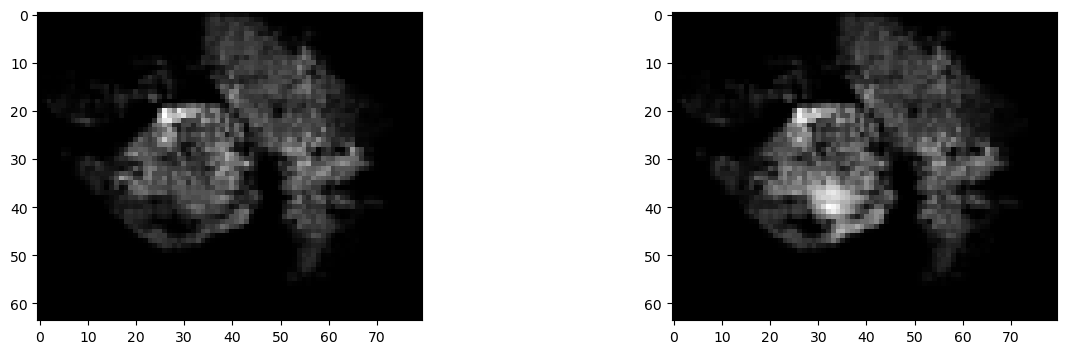

In [16]:
model_unet.load_weights('saved_models\\Unet_250_29.472.h5')
unet.model = model_unet
preds_image, predictions = unet.predict(selected_pix)

fig, axes = plt.subplots(1,2,figsize=(15,4))
axes[0].imshow(preds_image[0][0,:,:,0], cmap='gray')
axes[1].imshow(preds_image[1][0,:,:,0], cmap='gray')

In [17]:
df_2018['2018'] = [int(x) for x in predictions['2018']]
df_2019['2019'] = [int(x) for x in predictions['2019']]

In [18]:
print(df_2018['2018'].sum(), df_2018['2018'].sum()*0.8, df_2018['2018'].mean())
print(df_2019['2019'].sum(), df_2019['2019'].sum()*0.8, df_2019['2019'].mean())

306448 245158.40000000002 126.73614557485526
364664 291731.2 150.81224152191893


In [19]:
dfpred_2018 = df_2018[['Index','Latitude','Longitude','2018']]
dfpred_2019 = df_2019[['Index','Latitude','Longitude','2019']]
dfcluster = dfpred_2018.merge(dfpred_2019, on =['Index','Latitude','Longitude'])

dfcluster.head(5)

,Index,Latitude,Longitude,2018,2019
0,0,24.66818,71.33144,6,7
1,1,24.66818,71.41106,42,44
2,2,24.66818,71.49069,75,78
3,3,24.66818,71.57031,93,92
4,4,24.66818,71.64994,27,28


In [ ]:
dfcluster.to_csv('./dataset/dfcluster_Unet_29.csv',index=False)